# Group Meeting 3

Negentropy, Mutual information, total correlation, dual total correlation

### Readings 

Chapter 3, sections 3.2.2, 3.2.3, 3.3
https://link.springer.com/book/10.1007/978-3-319-43222-9

### Data
We'll be working with the same, binarized, HCP data as last time. 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns #Seaborn is a wrapper for matplotlib - it makes everything prettier.
sns.set(style="white")
from copy import deepcopy
from collections import Counter
from scipy.stats import zscore, entropy
import networkx as nx 
#To save disk space, I've saved the HCP data as a compressed .npz array.
#You can load it into the workspace with np.load(), although it cannot be directly accessed. 
data = np.load("data/HCP_BOLD.npz")
bold = zscore(data["signal"], axis=1) #Z-scored for data-hygiene reasons.
#For those that don't know: to z-score data is to subtract the mean, and divide by the standard deviation. 
#This results in data distributed around 0 w/ unit deviation. It does not make things Gaussian, but makes 
#things generally nicer.

discrete = deepcopy(bold) #This is a handy utility function, for Python-people whow haven't seen it before. 
discrete[discrete > 0] = 1 #Numpy indexing at work.
discrete[discrete < 0] = 0
discrete = discrete.astype("int16") #Use small integers if you can get away with it. Easier on RAM. 

### Negentropy

For a variable $X$ that can take on $k$ possible discrete states, the maximally entropy distribution occures when $P(k_i) = 1/k$ for all $k$. Consequently, the entropy is:

\begin{equation}
MaxEnt(X) = \log_2(k)
\end{equation}

We can think of this as a measure of how uncertain it is possible to be about the state of $X$. Often $H(X) < MaxEnt(X)$, and it is useful to have a measure of how much *more information* do we have about $X$ than the worst-case scenario. This is quantified with the *negentropy*:

\begin{equation}
N(X) = MaxEnt(X) - H(X)
\end{equation}

While entropy is naturally understood as a measure of uncertainty, negentropy is, to an extent, understood as a "true" measure of "information", if we consider having information to entail a reduction of uncertainty. 

A simple example is of a die - at the start of a game, you should assume that the die itself is maximally entropic: all outcomes are equally likely (in a sense, this is your prior). If you play for long-enough, you may realize that the die is not truly fair - you reallocate probabilities over the possible states, with more probable states becoming greater than $1/k$ and less probable states becoming less than $1/k$. This is your posterior. 

Negentropy quantifies the *reduction in uncertainty*, or alternately *the gain in predictive power (information)* you get as you play the game.

This should highlight the relationship between "uncertainty" and "information", as they are connected by the notion of increasing (or decreasing) your ability to *make predictions about a system.*

Note, another way of assessing the "distance" from maximal uncertainty is using the Kullback-Liebler divergence between the true distribution, and the MaxEnt distribution. This forms the basis of Jaynes alternative derivation of continuous entropy.

\begin{equation}
H_N(X) = D_{KL}(P(X) || MaxEnt(X))
\end{equation}

If this doesn't make too much sense, don't worry about it, but it's worth exploring on your own time, and we will come back to it when we discuss maximum entropy models and causality.

### Mutual Information

Mutual information can be thought of as a measure of how much knowledge of one variable ($X_1$) decreases our uncertainty about the state of another variable ($X_2$). Formally, it can be thought of as the $D_{KL}$ between the joint distribution of $X_1$ and $X_2$ and the product of the marginals. 

\begin{equation}
MI(X_1, X_2) = D_{KL}(P(X_1, X_2) || (P(X_1)P(X_2)))
\end{equation}

One way you could think of this is as a measure of how much information (or predictive power) is *lost* when we assume that $X_1$ and $X_2$ are independent. If they really are uncoupled, then $MI(X_1, X_2) = 0$, however, if there is a connection between them, then assuming independence costs us predictive power and $MI(X_1, X_2) > 0$. Expanding the math, we get:

\begin{equation}
MI(X_1 ; X_2) = \sum_{x_1\in\mathcal{X_1}}\sum_{x_2\in\mathcal{X_2}}P(x_1,x_2)\log\big(\frac{P(x_1,x_2)}{P(x_1)P(x_2)}\big)
\end{equation}

As with most other information theory measures, this is clearly an expectation over a distribution of combinations of $p(x,y)$ and $p(x)p(y)$, which we will discuss when we talk about local information measures. From this, we can also construct a Bayesian interpreation of mutual information:

\begin{equation}
MI(X_1 ; X_2) = \sum_{x_1\in\mathcal{X_1}}\sum_{x_2\in\mathcal{X_2}}P(x_1,x_2)\log\big(\frac{P(x_1|x_2)}{P(x_1)}\big)
\end{equation}

Recall that the $D_{KL}(X||Y)$ can be thought of as the predictive power *gained* when we go from a prior $Y$ to a posterior $X$. The mutual information can be thought of then, as the amount of predictive power gained when we update our information about $P(x_1)$ to include new information from $x_2$: $P(x_1|x_2)$.

Mutual information can also be written in terms of joint, conditional, and marginal entropies. We won't go through the derivation here, but if you are comfortable with algebra w/ logs and summations, it's not particularly difficult. There are two equivalent ways to decompose the mutual information between $X_1$ and $X_2$. It's worth remembering both, as they lead to different multivariate generalizations of MI.

\begin{eqnarray}
MI(X_1 ; X_2) &=& H(X_1) + H(X_2) - H(X_1,X_2) &(1)& \\
&=& H(X_1,X_2) - H(X_1|X_2) - H(X_2|X_1) &(2)&
\end{eqnarray}

#### Conditional Mutual Information

The conditional mutual information gives you a measure of how much information is shared between $X_1$ and $X_2$ that is *not accounted for* by some third variable $X_3$.

\begin{equation}
MI(X_1 ; X_2 | X_3) = H(X_1|X_3) + H(X_2|X_3) - H(X_1,X_2|X_3)
\end{equation}

How we got here is fairly clear: take $Eq. 1$ and condition every entropy of $X_3$. In general, this pattern holds. When reading it, it is important to remember that it is "the mutual information between ($X_1$ and $X_2$), conditioned on $X_3$". The core relationship is between $X_1$ and $X_2$ and the conditioning is done over both of them (as opposed to somehow being done just on $X_2$, which the notation might lead you to believe. That is to say that $MI(X_1;X_2|X_3) = MI(X_2;X_1|X_3)$. Less ambiguous notation would be $MI((X_1;X_2)|X_3)$, but if you do that in a paper, people will laugh at you.

Conditional mutual information is good for explaining away common driver effects. Imagine you have the following scenario:

Text(0.5,1,'Common Drivers')

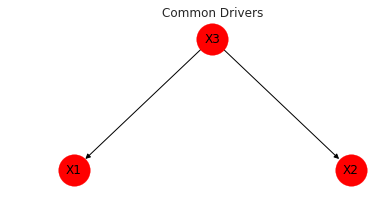

In [5]:
G = nx.DiGraph()
G.add_nodes_from(("X1","X2","X3"))
G.add_edges_from((("X3","X1"),("X3","X2")))

plt.figure(figsize=(6,3))
plt.subplot(1,1,1)
nx.draw_spectral(G, with_labels=True, node_size=10**3, edge_color="k")
plt.title("Common Drivers")

As with a correlation analysis (which cannot determine causation), you are almost certainly going to infer a significant mutual information between $X_1$ and $X_2$, because they share information from $X_3$. This would be a suprious edge in a network, however. By condition $MI((X_1,X_2)|X_3)$, however, you account from information coming from $X_3$ and so all that is left is whatever is shared between $X_1$ and $X_2$ *above and beyond* what is driven by $X_3$, which in this case should be zero. 

When doing linear/gaussian analysis, this is somewhat like "regressing-out" confounding variables, although the underlying mathematics are different (and, as usual, the information theoretic option is sensitive to nonlinear relationships, unlike standard linear regression approaches). 

### Multi-Variate Generalizations of Mutual Information

#### Total Correlation
Also known as the multi-information or integration, the total correlation of a multi-variate system $\textbf{X} = \{X_1, X_2, ... X_N\}$ is given by:

\begin{equation}
C(\textbf{X}) = \big(\sum_{i=1}^{N}H(X_i)\big) - H(\textbf{X})
\end{equation}

This is fairly obviously a generalization of Eq. $(1)$. Recall that the joint entropy is always less than, or equal to, the sum of the marginal entropies (with equality if and only if all the variables are independent). The total correlation can be thought of as a measure of "how much more structured is the whole than the sum of it's parts?"

Total correlation is also a natural generalization of the Kullback-Leibler divergence between multi-variate joint probabilities and the products of the marginals:

\begin{equation}
C(\textbf{X}) = D_{KL}(P(X_1,X_2...X_N)||P(X_1)P(X_2)...P(X_N))
\end{equation}

One way to think of it is as a measure of the *collective constraints* that the govern the behavior of the elements of the system: the capacity of each to act independently is constrained by the joint entropy of the whole.

The total correlation is *low* when all the elements are independent: in that case, the joint entropy and the sum of the marginals is the same. 

In contrast, the total correlation is high when every element is collectively behaving randomly. Consider the following examples:

Text(0.5,1,'Six Random, Uncorrelated Channels')

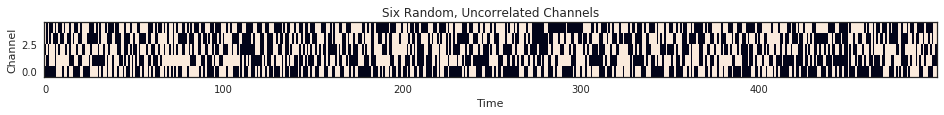

In [89]:
#low_struct is 6 random channels. No coordination between channels, or through time.
#Analagous to 6 disconnected, randomly firing neurons. 
low_struct = np.random.randint(0,2,(6,500))

plt.figure(figsize=(16,1))
plt.imshow(low_struct,aspect="auto")
plt.ylim([-0.5,4.5])
plt.xlabel("Time")
plt.ylabel("Channel")
plt.title("Six Random, Uncorrelated Channels")

In [95]:
#The joint entropy of the system is given by:
unq, counts = np.unique(low_struct, axis=1, return_counts = True)
probs = np.divide(counts, low_struct.shape[1])
H_joint = entropy(probs, base=2)
print("Joint Entropy:", H_joint, "bit")

H_total = 0.0
#The marginals entropies are given by:
for i in range(low_struct.shape[0]):
    C_i = list(Counter(low_struct[i]).values())
    H_i = entropy(C_i, base=2)
    H_total += H_i

print("Sum of Marginal Entropies:",H_total, "bit")
print("")
print("Total Correlation(low_structure)", H_total - H_joint, "bit")

Joint Entropy: 5.910657388658713 bit
Sum of Marginal Entropies: 5.978604019098304 bit

Total Correlation(low_structure) 0.06794663043959126 bit


Note that, despite the fact that we generated synthetically random channels, there is still a non-zero total correlation, even though we know analytically that it must be zero. There are several reasons for this: 1) Numpy's random number generator is not truely random (no computer can generate truely random numbers), so the initial data is not truely independent. 2) Naive entropy estimation *systematically underestimates* the true entropy - in this case, the true joint entropy should be 6 bit. The more variables in the joint entropy (i.e. the more probabilities to infer), the worse the bias. Notice that the sum of the marginals is *much* closer to 6, since there's less bias in the inference of each marginal probability.

To create an example where total correlation will be near-maximal:

Text(0.5,1,'Six Synchronized Channels')

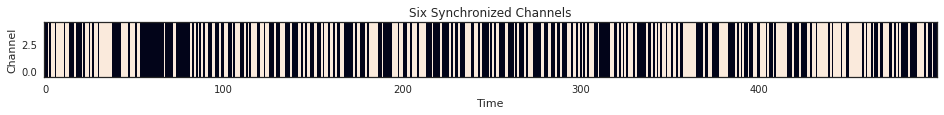

In [86]:
ex = np.random.randint(0,2,500)
high_struct = np.array([ex for i in range(6)])

plt.figure(figsize=(16,1))
plt.imshow(high_struct,aspect="auto")
plt.ylim([-0.5,4.5])
plt.xlabel("Time")
plt.ylabel("Channel")
plt.title("Six Synchronized Channels")

In [94]:
#The joint entropy should be approximately 1 bit. 
unq, counts = np.unique(high_struct, axis=1, return_counts = True)
probs = np.divide(counts, high_struct.shape[1])
H_joint = entropy(probs, base=2)
print("Joint Entropy:", H_joint, "bit")

#The sum of the total entropies will just be 6 times the entropy of ex 
C_ex = list(Counter(ex).values())
H_ex = entropy(C_i, base=2)
H_total = 6*H_ex

print("Sum of Marginal Entropies:",H_total, "bit")
print("")
print("Total Correlation(high_structure)", H_total - H_joint, "bit")

Joint Entropy: 0.9986030202378096 bit
Sum of Marginal Entropies: 5.960050873128322 bit

Total Correlation(high_structure) 4.961447852890513 bit


It is clear that total correlation will be highest when the joint entropy of the system is minimal (there are very few unique joint-configurations), but each element is highly entropic. This can be related to synchronization processes, as well as "bursty" time-series.

#### Dual Total Correlation

Recall that $MI(X_1;X_2) = H(X_1,X_2) - H(X_1|X_2) - H(X_2|X_1)$ (eq. 2 given above). An alternative generalization of mutual information comes from the recognition that the last two conditional entropy terms are residual entropies, where $R(X_i) = H(X_i | X^{-i})$. When $\textbf{X} = \{X_1, X_2\}$, then $R(X_1) = H(X_1 | X_2)$ and vice-versa. 

For a bivariate mutual information, we can replace the condition entropies with residual entropies:

\begin{equation}
MI(X_1;X_2) = H(X_1,X_2) - [R(X_1) + R(X_2)]
\end{equation}

For a multi-variate system $(\textbf{X})$, we define the dual total correlation:

\begin{equation}
D(\textbf{X}) = H(X_1, X_2, ... X_N) - \sum_{i=1}^{N}H(X_i | X^{-i})
\end{equation}

This creates a very different understanding of mutual information. Dual total correlation defines mutual information as all of the information that is *jointly shared* by two or more elements. By subtracting off the sub of all the residual entropies, we remove all the information that is unique to each element, leaving only the information that is synergistically shared by groups of 2 or more elements. 

As with total correlation, dual total correlation is *low* when all elements are independent (the joint entropy is equivalent to the sum of the residual entropies), and high when the residual entropies are low (the behavior of any element can be predicted from the behavior of the neighbors), *however*, the dual total correlation will be highest when the joint entropy of the system is also high (in contrast to the total correlation). They do **not** return the same values.

Consider the highly structured example from above:

Text(0.5,1,'Six Synchronized Channels')

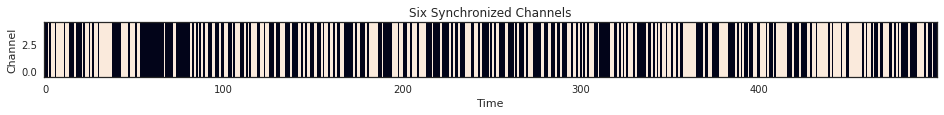

In [96]:
plt.figure(figsize=(16,1))
plt.imshow(high_struct,aspect="auto")
plt.ylim([-0.5,4.5])
plt.xlabel("Time")
plt.ylabel("Channel")
plt.title("Six Synchronized Channels")

In [107]:
#The joint entropy is the same as in the total correlation
unq, counts = np.unique(high_struct, axis=1, return_counts = True)
probs = np.divide(counts, high_struct.shape[1])
H_joint = entropy(probs, base=2)
print("Joint Entropy:", H_joint, "bit")

#The sum of the residuals entropies will be 6 times the residual entropy of any one channel. 
#Remember that H(X|Y) = H(X,Y) - H(Y), so:
#H(Ch_i | Ch_inv_i) = H(Ch_i , Ch_inv_i) - H(Ch_inv_i)
#And H(Ch_i, Ch_inv_i) is obviously just the total joint entropy calculated above.

Ch_inv_i = high_struct[1:,:]
unq, counts = np.unique(Ch_inv_i, axis=1, return_counts = True)
probs = np.divide(counts, Ch_inv_i.shape[1])
H_inv_i = entropy(probs, base=2)
print("R(Ch_i):", H_joint - H_inv_i, "bit")

print("")
print("Dual total correlation (high structure)", H_joint - (6*(H_joint-H_inv_i)), "bit")


Joint Entropy: 0.9986030202378096 bit
R(Ch_i): 0.0 bit

Dual total correlation (high structure) 0.9986030202378096 bit


Here, $D(\textbf{X})=H(\textbf{X})$, while $C(\textbf{X}) > H(\textbf{X})$.

It's worth investigating this a little bit. The dual total correlation defines mutual information as only that information which is synergistically shared between 2 or more elements of the system - in the case of the highly structured example, the residual entropy of each channel is 0, since the state of any channel can always be predicted with total accuracy from the joint states of the remaining 5 channels. So, the calculation works out to the joint entropy - 6 times 0. 

The dual total correlation is an interesting measure because it is low when the system is totally random (as in the low-structure example array), and when it is totally ordered (as in the high-structure example) and the number of unique joint states is low. It is highest when the system is globally highly variable, but the constraints are such that any individual channels can be predicted from the other elements of the system. 

### A Warning About Redundency & Synergy

Multi-variate generalizations of mutual information can be extremely useful when trying to understand the global behavior of complex systems. They often do not give you insight into how information is distributed redundantly, specifically, or synergistically over the channels. 

#### Redundant or Unique Information

Consider two channels from our fMRI data known to have a high mutual information: Ch. 4 and Ch. 5 

In [39]:
def mutual_information(X,Y):
    H_joint = entropy(list(Counter(zip(X,Y)).values()), base=2)
    H_X = entropy(list(Counter(X).values()), base=2)
    H_Y = entropy(list(Counter(Y).values()), base=2)
    return H_X + H_Y - H_joint

def total_correlation(X):
    unq, counts = np.unique(X, axis=1, return_counts=True)
    H_joint = entropy(counts, base=2)
    H_sum = 0.0
    for i in range(X.shape[0]):
        H_sum += entropy(list(Counter(X[i]).values()), base=2)
    return H_sum - H_joint

def dual_total_correlation(X):
    unq, counts = np.unique(X, axis=1, return_counts=True)
    H_joint = entropy(counts, base=2)
    R_sum = 0.0
    for i in range(X.shape[0]):
        X_inv = X[[x for x in range(X.shape[0]) if x != i]]
        unq, counts = np.unique(X_inv, axis=1, return_counts=True)
        H_shared = entropy(counts, base=2)
        R_sum += H_joint - H_shared
    
    return H_joint - R_sum

Note that in the 2-element case, the mutual infrormation, total correlation, and dual total correlation are all identical.

In [15]:
print("MI(Ch.4 ; Ch.5)", mutual_information(discrete[4], discrete[5]), "bit")

MI(Ch.4;Ch.5) 0.3320531969323486 bit


In [22]:
print("C(Ch.4 ; Ch.5)", total_correlation(discrete[4:6]), "bit")

C(Ch.4 ; Ch.5) 0.3320531969323488 bit


In [40]:
print("D(Ch.4 ; Ch.5)", dual_total_correlation(discrete[4:6]), "bit")

D(Ch.4 ; Ch.5) 0.3320531969323488 bit


Now I am going to add three totally random channels to the set of Ch. 4 and Channel 5. 

In [49]:
array = np.vstack((discrete[4], 
                   discrete[5], 
                   np.random.randint(0,2,discrete.shape[1]),
                   np.random.randint(0,2,discrete.shape[1]),
                   np.random.randint(0,2,discrete.shape[1])))

print("TC(Array) ", total_correlation(array), "bit")
print("DTC(Array)", dual_total_correlation(array), "bit")

TC(Array)  0.34887589754656645 bit
DTC(Array) 0.3571946166827722 bit


Note that the TC and DTC are essentially the same: adding random channels to the system doesn't increase the overall multi-variat emutual infromation, no matter how you look at it (allowing some wiggle room for bias from fininte sample sizes).

If we look at the TC and DTC of *either* Ch. 4 *or* Ch. 5 with the random channels we see that there is essentially nothing:

In [55]:
print("TC(Ch.4 + Random) ", total_correlation(array[[0,2,3,4]]), "bit")
print("TC(Ch.5 + Random) ", total_correlation(array[[1,2,3,4]]), "bit")
print("")
print("DTC(Ch.4 + Random)", dual_total_correlation(array[[0,2,3,4]]), "bit")
print("DTC(Ch.5 + Random)", dual_total_correlation(array[[1,2,3,4]]), "bit")

TC(Ch.4 + Random)  0.006042180635299044 bit
TC(Ch.5 + Random)  0.010357018871335999 bit

DTC(Ch.4 + Random) 0.009384599026306617 bit
DTC(Ch.5 + Random) 0.010955027042687693 bit


It seems like *all* of the information present in the set of five channels (the two empirical ones + three random ones) is contained *only* in the interaction between the two real channels. This seems obvious when you know what you're looking at, however, if you were presented with these data and had no idea how they were generated, and just did a total correlation, or dual total correlation analysis on the full set, you wouldn't necessarilly see how inforamtion is distributed across all five components.

#### Synergistic Information

The above example is one where information is uniquely contained only in a subset of all the channels. The opposite case is also possible: below, we create two random channels (for which the mutual information should be ~0), and then a third channel that is the XOR of the two. This will result in three channels, for which any pairwise comparison should have no mutual information, but signficant information in it's joint structure.

In [59]:
X1 = np.random.randint(0,2,1200)
X2 = np.random.randint(0,2,1200)
print("MI(X1 ; X2)", mutual_information(X1, X2), "bit")
XOR_12 = np.logical_xor(X1, X2)
print("MI(X1 ; XOR_12)", mutual_information(X1, XOR_12), "bit")
print("MI(X2 ; XOR_12)", mutual_information(X2, XOR_12), "bit")

MI(X1 ; X2) 0.0011392639145775263 bit
MI(X1 ; XOR_12) 0.00022726641005288428 bit
MI(X2 ; XOR_12) 0.00014710918879679014 bit


In [63]:
array = np.vstack((X1,X2,XOR_12))
print("TC(Array) ", total_correlation(array), "bit")
print("DTC(Array) ", dual_total_correlation(array), "bit")

TC(Array)  0.9999847999097791 bit
DTC(Array)  1.9984559603061314 bit


Note that pairwise mutual information doesn't detect any information for any pair. If you were a neuroscientist attempting to do functional connectivity on these three time-series, you would decide that your network had no edges and all the nodes were independent. We know, however, that there is a connected, causal generative model that is only visible when you look at the system jointly.

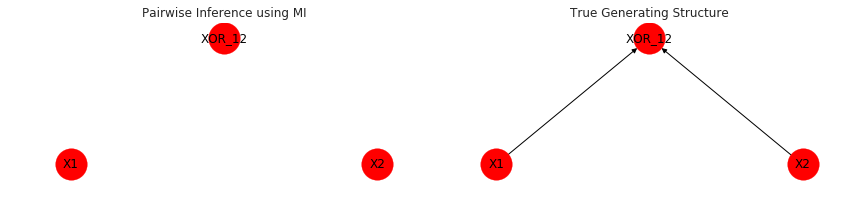

In [93]:
G = nx.DiGraph()
G.add_nodes_from(("X1","X2","XOR_12"))
G.add_edges_from((("X1","XOR_12"),("X2","XOR_12")))

plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
nx.draw_spectral(G, with_labels=True, node_size=10**3, edge_color="white")
plt.title("Pairwise Inference using MI")

plt.subplot(1,2,2)
nx.draw_spectral(G, with_labels=True, node_size=10**3)
plt.title("True Generating Structure")
plt.tight_layout()

This is another case where conditional mutual information will reveal meaningful relationships. In the introduction, we described how conditional MI can remove common-driver effects. It will also help discover synergies. As with the total correlation, when we do $MI((X_1,XOR_12)|X_2)$, suddenly we have all the information we need to "see" the relationship. The $X_2$ variable provides the "context" which makes the relationship between both and the $XOR$-gate meaningful. 